-A*v**(-1.7) + 1.47449944028424e-47*v**4.75/(exp(4.79924466221135e-11*v/T) - 1)


1.7*A + 5.763383252268e-34

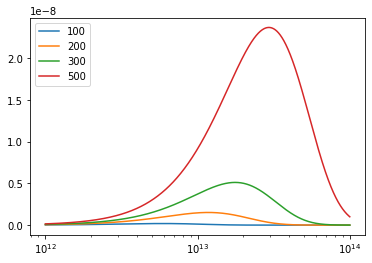

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sym
import astropy.constants as const
from astropy import units as u
from astropy.modeling.blackbody import blackbody_nu
%matplotlib inline

#B = lambdify((T, v), blackbody, modules='numpy')

#def sed(nu_obs, z, beta=1.75, gamma=1.7, alpha=0.36):
def sed(beta=1.75, gamma=1.7, alpha=0.36):

    # Defining physical constants
    c = const.c.cgs.value
    h = const.h.cgs.value
    k_B = const.k_B.cgs.value
    
    # Undoing Redshift: from Observing to Original
    #nu_o = nu_obs * (1+z)
    #temp_obs = 24.4
    #temp_o = temp_obs * (1+z)**alpha
    
    #get temperature in nu_o for the sympy
    
    #Find the nu_o
    sym.var('v T A', real=True)
    blackbody = (2*const.h.cgs.value/const.c.cgs.value**2) * v**3 / (sym.exp((v/T) * (const.h.cgs.value/const.k_B.cgs.value)) - 1)
    eq1 = v**beta * blackbody - A*v**(-gamma)
    n = 1
    eq2 = (sym.diff(eq1, v)).subs(v, n)
    
    
    return eq1, sym.lambdify(T,eq2,'numpy')

nu = np.logspace(12, 14, 2000)
# bb = (2*const.h.cgs.value/const.c.cgs.value**2) * (nu)**3 / (np.exp((nu/T) * (const.h.cgs.value/const.k_B.cgs.value)) - 1)
# plt.plot(nu, bb, label='mine')
plt.plot(nu, blackbody_nu(nu, 100), label='100')
plt.plot(nu, blackbody_nu(nu, 200), label='200')
plt.plot(nu, blackbody_nu(nu, 300), label='300')
plt.plot(nu, blackbody_nu(nu, 500), label='500')

plt.xscale('log')
plt.legend(loc='upper left');

e1, e2 = sed()
print(e1) 
e2(500)

In [152]:
e1, e2 = sed()

print(sym.latex(e1))

- \frac{A}{v^{1.7}} + \frac{1.47449944028424 \cdot 10^{-47} v^{4.75}}{e^{\frac{4.79924466221135 \cdot 10^{-11} v}{T}} - 1}


In [88]:
def test(temp):
    sym.var('x y')
    return A * sym.cos(x) + B * sym.sin(x)

def sysEquations(var, temps):
    pdb.set_trace()
    e1, e2 = eqs
    
    return (e1, e2)


M = sym.Matrix([1, 2, 5])

eq1 = M.applyfunc(test)
eq2 = eq1.diff(s)
    
leq1 = sym.lambdify([s,r], eq1)
leq2 = sym.lambdify([s,r], eq2)
    
fsolve(lambda eqs: (eqs[0], eqs[1]), x0=[np.pi, 4])

#print(np.shape(lameqs(2,5)))
#fsolve(lameqs, (1,1))

array([0., 0.])

In [33]:
sym.var('x K')
a = x * sym.exp(sym.Array([500,100,600])/K)
print(a)
sym.nonlinsolve([a, sym.diff(a,x)], [x, K])

#T = sym.Array([500,100,600])
#T.applyfunc(lambda sym.exp) - 1
print(a)

x*exp([500/K, 100/K, 600/K])


AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'could_extract_minus_sign'

In [23]:
from scipy.optimize import fsolve
def equations(z):
    v, t = z
    
    return (v+t**2-4, sym.exp(v) + v*t - 3)

sol = fsolve(equations, (1,1))
print(sol)
print(equations(sol))

[0.62034452 1.83838393]
(4.4508396968012676e-11, -1.05120356863608e-11)
